# Supervised Machine Learning Techniques for Anamaly Detection

### Generalized Linear Model and Auto ML

Anderson Nelson  <br>
Date: 11/24/2019 <br>

### Introduction

In this exercise, I will walk you through my approach to create a model to identify fraud in financial transaction data. I will cover data preparing the data and train two different model Generalized Linear Model and Auto ML performance by tuning the parameters.  

In [1]:
import numpy as np
import datetime
import h2o 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML

import warnings
warnings.filterwarnings('ignore')

In [2]:
def VarImp(model_name):    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
def createGains(model, test_hex):
    predictions = model.predict(test_hex)
    
    predictions = predictions.as_data_frame()
    test_hex = test_hex.as_data_frame()

    test_hex['loan_default'] = np.where(test_hex['loan_default'] == 'No', 0,1)
    predictions['predict'] = np.where(predictions['predict'] == 'No',0,1)

    test_scores = pd.concat([predictions['predict'],test_hex['loan_default']], axis=1)


    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)


def ROC_AUC(my_result,df,target):
    
    y_pred = my_result.predict(df).as_data_frame()
    df = df.as_data_frame()
    df[target] = np.where(df[target] == 'No', 0,1)
    # ROC
    y_actual = df[target]
    
    y_pred['predict'] = np.where(y_pred['predict'] == 'No', 0,1)
    
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred['predict'])
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred['predict'])

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(9,6))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred['predict'])
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()
    

def plot_auc(model):
    plt.figure(figsize=(9,6))
    plt.plot(model.roc()[0],model.roc()[1],color='darkorange',lw=2)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic: AUC={model.auc():0.4f}')
    plt.show()
    
def column_scaler(data): 
    data_scaler = StandardScaler()
    for value in data.columns: 
        testing_data = pd.DataFrame(data.loc[:,value])
        data.loc[:,value] = data_scaler.fit_transform(testing_data)
        return data
    
    
def correlation_threshold(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset    

def normalized(data): 
    """Calculates the z score between two data sets"""
    mean = data.mean()
    sd = data.std()
    score = (data - mean) / sd
    return score 

def column_scaler(data, column_skip): 
    """ 
    Scales each column in the dataset 
    """
    new_data = pd.DataFrame()
    
    for value in data.columns: 
        if value in column_skip: 
            new_data[value] = data[value]
        else: 
            column_data = data[value]
            new_data[value] = normalized(column_data)
    return new_data

In [3]:
# read data 
data = pd.read_csv('Data/XYZloan_default_selected_vars.csv')

# drop neccessary columns 
data = data.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

The first thing i wanted to do is check whether the data contains any duplicate id.

In [4]:
# are there any duplicated id 
sum(data.id.duplicated())

0

The first step to an analysis is to understand the data. Lets start with understanding how missing values.

In [5]:
f'{round(sum(data.isna().sum()) /(data.shape[1] * data.shape[0]),2) * 100}% of the data is missing'

'9.0% of the data is missing'

In [6]:
f'{round(sum(data.isnull().sum()) /(data.shape[1] * data.shape[0]),2) * 100}% of the data is null'

'9.0% of the data is null'

The number of missing values represents a small percentage of the dataset. However, those values shouldn’t be ignored. There are a number of different strategies to deal with missing values.

    1. Imputation
    2. Deletion

Exploring the colums with missing data will allow us to determine the best strategy to solve the missing data problem.

In [7]:
col_missing = round((data.isna().sum() / data.shape[0]) * 100,2)

The graph shows us that there are a few collumn where more than 99% of the data is missing or null

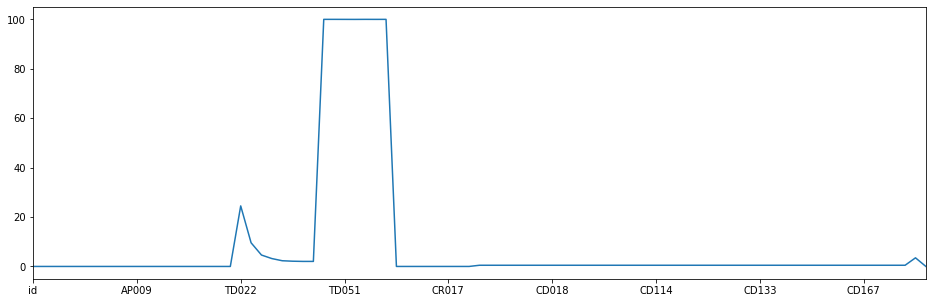

In [8]:
fig = plt.figure(figsize=(16,5))
col_missing.plot()
plt.show()

In [9]:
col_missing[col_missing > 99]

TD044    100.00
TD048    100.00
TD051     99.99
TD054     99.98
TD055    100.00
TD061     99.99
TD062    100.00
dtype: float64

We will remove those columns since 

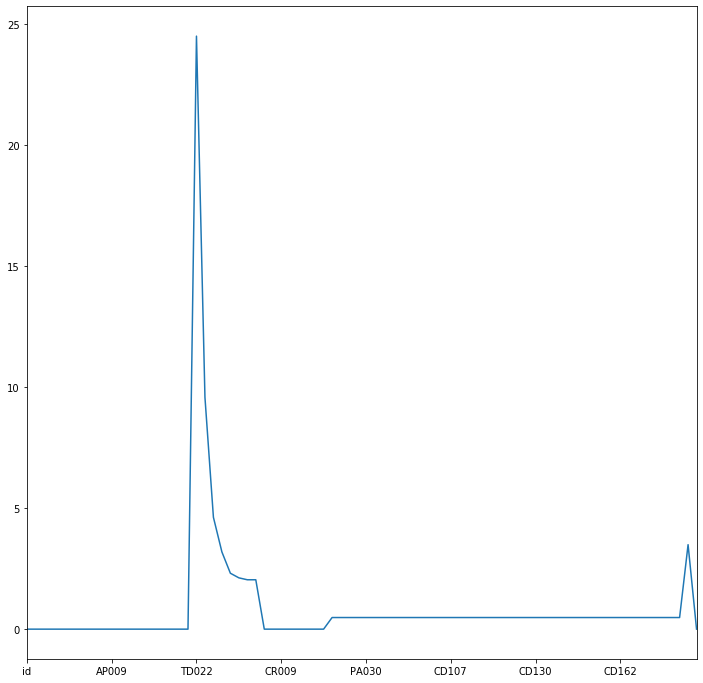

In [10]:
data = data.drop(columns=col_missing[col_missing > 99].index)
col_missing = round((data.isna().sum() / data.shape[0]) * 100,2)
fig = plt.figure(figsize=(12,12))
col_missing.plot()
plt.show()

A few users represent the missing values in the data; after further analysis, it seems that missing patterns exist from a distinct group of users. The columns that have missing values also follow a pattern; they are all related to the phone. There are several reasons why that column could be missing: but the most likely reason is that those people don’t have a phone number, or it was never provided to the company.

The best option is to either remove them from the data or impute with 0. If we exclude from the data, a small but essential segment of our population could be misrepresented; on the contrary, if we include it could potentially skew the analysis since we assumed the missing values.

However, inputting the values with 0 makes the most sense for this data since, given that the users do not have a phone, the bank would be unable to call, leave voicemails and converse with the client, which is fair.

In [11]:
col_missing.sort_values(ascending=False)

TD022    24.50
TD023     9.58
TD024     4.62
MB005     3.49
TD025     3.19
         ...  
CR015     0.00
CR017     0.00
CR018     0.00
CR019     0.00
id        0.00
Length: 80, dtype: float64

In [12]:
data = data.fillna(0)

The MB007 column contains many categorical values. I discovered that the top 9 values contribute to over 90% of the distribution. I gave the other categories the value of 'Other'. 

In [13]:
MB007_value_count = pd.DataFrame(data.MB007.value_counts())
MB007_value_count['cum_sum'] = MB007_value_count.cumsum()
MB007_value_count['%'] = MB007_value_count['cum_sum'] / 80000
MB007_value_count = MB007_value_count.drop(index='Noinfo')

In [14]:
data['MB007'] = data['MB007'].apply(lambda i: i if i in MB007_value_count[1:10].index else 'Other')

In [15]:
MB007_columns = list(pd.get_dummies(data.MB007).columns)
AP006_columns = list(pd.get_dummies(data.AP006).columns)
columns_skip = MB007_columns + AP006_columns

Since the values in column MBOO7 and AP006 are not ordinal, to prevent the model from assigning a higher value to the categorical data. I will One hot encode the variables 

In [16]:
data = pd.concat([data.reset_index(drop=True), pd.get_dummies(data.MB007)], axis=1)
data = pd.concat([data.reset_index(drop=True), pd.get_dummies(data.AP006)], axis=1)
data = data.drop(columns=['MB007','AP006','AP004'])

The date field can be misleading, it can become a unique identifier for each record. I'm going to split into date and time. 

In [17]:
date_time = data['AP005'].str.split(' ',1,expand=True)
date_time.columns = ['Date','Time']
columns_skip = columns_skip + list(date_time.columns)

After searching throughout the entire model for abnormalities, I found that the are numerous -99 value, which is another form of Null recorded. A small number of users have a considerable proportion of 99 values in their records. Those users can skew the model results, and I remove them.

In [18]:
# how many -99 values per user id 
user_list_99 = []
for row in range(0, len(data)):
    row_data = data.iloc[row]
    user_list_99.append(list(row_data).count(-99))

In [19]:
_99_count= pd.DataFrame({'id': data.iloc[:,0],
             '99_count' : user_list_99})

In [20]:
# how many id have more than 1 -99 values and how many 99 values exsist 
_99_count[_99_count['99_count'] > 0]
_99_count[_99_count['99_count'] > 0]['99_count'].value_counts()

36    1773
42    1534
Name: 99_count, dtype: int64

In [21]:
f'{round((len(_99_count[_99_count["99_count"] > 0]["99_count"]) / len(data)) * 100,2)}% of users have more than 36 values labels as -99 in their respective row'

'4.13% of users have more than 36 values labels as -99 in their respective row'

In [22]:
# remove the ids with -99 values 
_99_count[_99_count['99_count'] > 0]['id'].values
data = data[~data.iloc[:,0].isin(_99_count[_99_count['99_count'] > 0]['id'].values)].reset_index()

Lastly, I found that the date variable had predictive power in my model, However, it doesn't make sense to include in my model. 

In [23]:
# covert AP005 into date and time 
data = data.drop(columns='AP005')

Convert 0 = No and 1 = Yes in the default

In [24]:
# convert the loan_faults into categerical 
data['loan_default'] = np.where(data['loan_default'] == 0, 'No','Yes')

#### Standardized valriables: 

The dataset contains features highly varying in magnitudes, units and range. It is necessary to standardize variables before using regression models


In [25]:
columns_skip.append('loan_default') 
data = column_scaler(data, columns_skip)

The data containts  a number of highly correlated features, multicollinearity can negatively impact the prediction and interpretability of linear models.  Multicollinearity increases the variance of the coefficient estimates and makes the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret. Multicollinearity saps the statistical power of the analysis, can cause the coefficients to switch signs, and makes it more difficult to specify the correct model.

In order to address this, I'm going to remove the columns with more than than 0.8 correlation. 

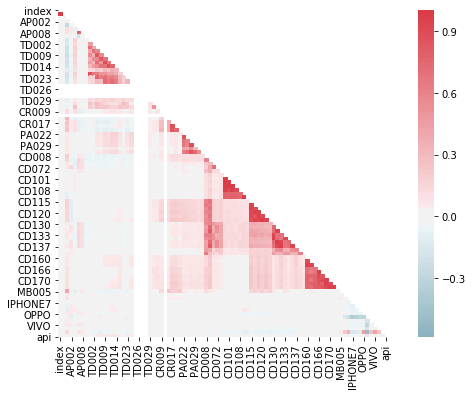

In [26]:
fig = plt.figure(figsize=(8,6))
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and caorrect aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True)
plt.show()

In [27]:
data = correlation_threshold(data,0.80)

In [30]:
clean_data= data.drop(columns=['index'])

In [31]:
train, test = train_test_split(clean_data, test_size=0.30, random_state=23)
train, val = train_test_split(train, test_size=0.20, random_state=23)

target = 'loan_default'
predictors = train.columns[1:]

In [32]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from C:\Users\ander\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ander\AppData\Local\Temp\tmpp2d2die3
  JVM stdout: C:\Users\ander\AppData\Local\Temp\tmpp2d2die3\h2o_ander_started_from_python.out
  JVM stderr: C:\Users\ander\AppData\Local\Temp\tmpp2d2die3\h2o_ander_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_ander_od5rwm
H2O cluster total nodes:,1
H2O cluster free memory:,3.516 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [33]:
# full data
train_full = h2o.H2OFrame(train)
test_full = h2o.H2OFrame(test)
val_full = h2o.H2OFrame(val)


# sample data to test 
train_smpl = train.sample(frac=0.25, random_state=1)
test_smpl = test.sample(frac=0.25, random_state=1)
val_smpl = val.sample(frac=0.25, random_state=1)


train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)
val_hex = h2o.H2OFrame(val_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


### Generalized Linear Model: 
#### Model 1 

For the first model I'm going to use the standard parameters to measure performance against 

In [34]:
glm_v1 = H2OGeneralizedLinearEstimator(family= "binomial") 
glm_v1.train(list(predictors),target,training_frame=train_full, validation_frame = val_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [35]:
glm_v1.gains_lift()


Gains/Lift Table: Avg response rate: 19.41 %, avg score: 19.41 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.492721,2.443964,2.443964,0.474419,0.559840,0.474419,0.559840,0.024469,0.024469,144.396428,144.396428
1,,2,0.020001,0.444724,1.945319,2.194932,0.377622,0.465578,0.426077,0.512764,0.019431,0.043901,94.531916,119.493197
2,,3,0.030013,0.414677,1.988716,2.126140,0.386047,0.428747,0.412723,0.484736,0.019911,0.063812,98.871603,112.614000
3,,4,0.040002,0.393449,1.957327,2.083986,0.379953,0.403652,0.404540,0.464489,0.019551,0.083363,95.732731,108.398596
4,,5,0.050014,0.375858,2.048617,2.076906,0.397674,0.384439,0.403166,0.448464,0.020511,0.103874,104.861712,107.690560
5,,6,0.100005,0.321405,1.852330,1.964644,0.359571,0.345975,0.381374,0.397231,0.092599,0.196474,85.233016,96.464403
6,,7,0.150019,0.288513,1.664402,1.864548,0.323091,0.304161,0.361943,0.366203,0.083243,0.279717,66.440241,86.454796
7,,8,0.200009,0.264673,1.509217,1.775736,0.292967,0.276122,0.344703,0.343688,0.075447,0.355164,50.921719,77.573595
8,,9,0.300014,0.229189,1.351742,1.634405,0.262398,0.246094,0.317268,0.311157,0.135181,0.490344,35.174226,63.440472
9,,10,0.399995,0.201600,1.130113,1.508354,0.219376,0.215009,0.292799,0.287124,0.112990,0.603335,13.011335,50.835389


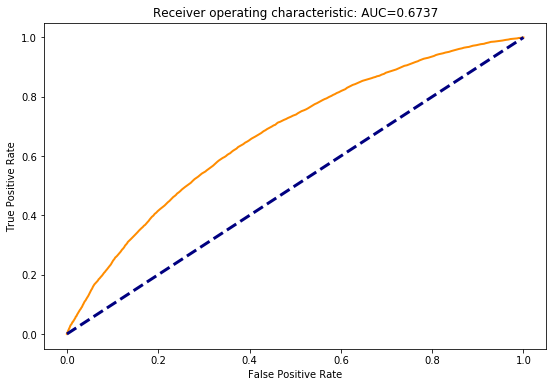

In [36]:
plot_auc(glm_v1)

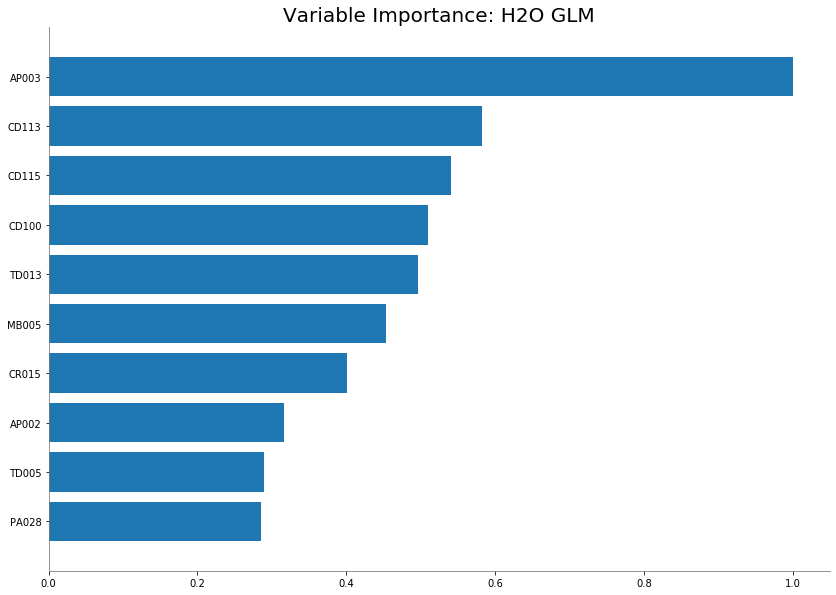

In [37]:
glm_v1.varimp_plot()

Test set performance

In [38]:
glm_v1_test = glm_v1.model_performance(test_data=val_full)

In [39]:
glm_v1_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.79 %, avg score: 19.37 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010059,0.489941,2.713490,2.713490,0.537037,0.555753,0.537037,0.555753,0.027294,0.027294,171.349020,171.349020
1,,2,0.020024,0.444190,1.652754,2.185589,0.327103,0.464688,0.432558,0.510432,0.016471,0.043765,65.275426,118.558906
2,,3,0.030083,0.415031,1.964941,2.111812,0.388889,0.428465,0.417957,0.483025,0.019765,0.063529,96.494118,111.181206
3,,4,0.040048,0.394666,2.313856,2.162088,0.457944,0.404861,0.427907,0.463575,0.023059,0.086588,131.385596,116.208810
4,,5,0.050014,0.378442,2.030527,2.135874,0.401869,0.386580,0.422719,0.448233,0.020235,0.106824,103.052666,113.587381
5,,6,0.100028,0.320301,1.740690,1.938282,0.344507,0.345950,0.383613,0.397091,0.087059,0.193882,74.069011,93.828196
6,,7,0.150042,0.289601,1.712463,1.863009,0.338920,0.303214,0.368715,0.365799,0.085647,0.279529,71.246270,86.300887
7,,8,0.200056,0.264759,1.420779,1.752452,0.281192,0.276450,0.346834,0.343462,0.071059,0.350588,42.077949,75.245153
8,,9,0.299991,0.229518,1.323216,1.609462,0.261883,0.245839,0.318535,0.310941,0.132235,0.482824,32.321561,60.946173
9,,10,0.400019,0.199679,1.171437,1.499930,0.231844,0.213996,0.296857,0.286699,0.117176,0.600000,17.143740,49.993015


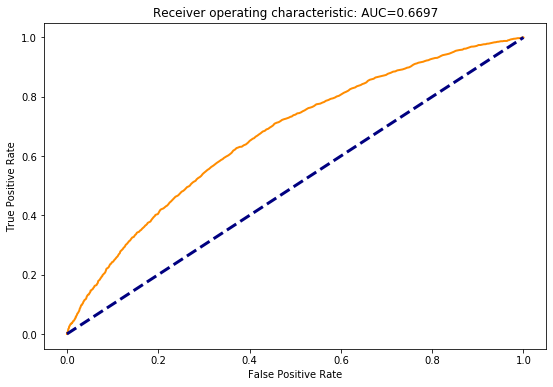

In [40]:
plot_auc(glm_v1_test)

In [41]:
glm_v1_test.pr_auc()

0.3228003814480271

### Model: 2


Since we large number of features, some of which may have prediction power, I used the regularization techniques used to address over-fitting and feature selection. 

`L1 Regularization` = Lasso Regression <br>
`L2 Regularization` = Ridge Regression


The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features.

Traditional methods like cross-validation, stepwise regression to handle overfitting and perform feature selection work well with a small set of features but these techniques are a great alternative when we are dealing with a large set of features.

The alpha parameter controls the distribution between the 1 `(Lasso)` and 2 `(Ridge regression)` penalties. A value of 1.0 for alpha represents Lasso, and an alpha value of 0.0 produces ridge regression. The lambda parameter controls the amount of regularization applied. If lambda is 0.0, no regularization is applied and the alpha parameter is ignored.

I'm testing out a variety of paramters for L1 and L2  Regularization. 

In [42]:
glm_v2 = H2OGeneralizedLinearEstimator(family= "binomial", seed = 121, nfolds = 4,remove_collinear_columns = True) 

hyper_params = {'alpha': [x/100. for x in range(0,100,5)],
                'lambda': [x/100. for x in range(0,100,5)],
               }

glm_grid = H2OGridSearch(model = glm_v2, hyper_params = hyper_params,
                     search_criteria = {'strategy': "RandomDiscrete",'max_models': 36, 
                                        'seed': 1,"stopping_metric": "AUCPR",
                                        "stopping_tolerance": 0.05, 
                                        "stopping_rounds": 3})

In [43]:
glm_grid.train(list(predictors),target,training_frame=train_full, validation_frame = val_hex)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [45]:
sorted_glm_v2 = glm_grid.get_grid(sort_by='f1',decreasing=True)
glm_v2 = sorted_glm_v2.models[0]

In [46]:
glm_v2_test = glm_v2.model_performance(test_data=val_hex)

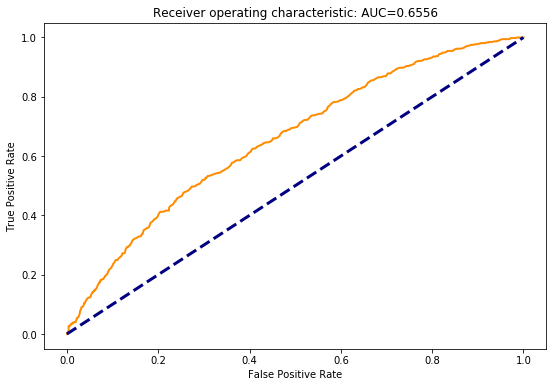

In [47]:
plot_auc(glm_v2_test)

In [48]:
glm_v2_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.71 %, avg score: 19.26 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010060,0.486174,2.630820,2.630820,0.518519,0.571033,0.518519,0.571033,0.026465,0.026465,163.081986,163.081986
1,,2,0.020119,0.438810,1.315410,1.973115,0.259259,0.459576,0.388889,0.515304,0.013233,0.039698,31.540993,97.311489
2,,3,0.030179,0.411304,1.503326,1.816518,0.296296,0.422785,0.358025,0.484464,0.015123,0.054820,50.332563,81.651847
3,,4,0.040238,0.392684,2.630820,2.020094,0.518519,0.401791,0.398148,0.463796,0.026465,0.081285,163.081986,102.009382
4,,5,0.050298,0.374908,2.067073,2.029490,0.407407,0.382536,0.400000,0.447544,0.020794,0.102079,106.707274,102.948960
5,,6,0.100224,0.317407,1.665999,1.848420,0.328358,0.344349,0.364312,0.396138,0.083176,0.185255,66.599893,84.841990
6,,7,0.150149,0.289537,1.703863,1.800354,0.335821,0.300769,0.354839,0.364427,0.085066,0.270321,70.386254,80.035368
7,,8,0.200075,0.263820,1.400954,1.700690,0.276119,0.275772,0.335196,0.342305,0.069943,0.340265,40.095364,70.068961
8,,9,0.299925,0.227612,1.382022,1.594599,0.272388,0.244081,0.314286,0.309604,0.137996,0.478261,38.202184,59.459897
9,,10,0.400149,0.197522,0.905349,1.421965,0.178439,0.211727,0.280261,0.285089,0.090737,0.568998,-9.465148,42.196548


In [49]:
glm_v2_test.pr_auc()

0.30600938064856914

#### Best Model

I evaluated the performance of both models, and I found that the best model is model 2

In [50]:
final_test = glm_v2.model_performance(test_data=test_full)

In [51]:
final_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.29 %, avg score: 19.31 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010040,0.492209,2.355977,2.355977,0.454545,0.553755,0.454545,0.553755,0.023654,0.023654,135.597698,135.597698
1,,2,0.020037,0.443470,2.456362,2.406061,0.473913,0.464600,0.464208,0.509274,0.024555,0.048209,145.636209,140.606066
2,,3,0.030033,0.414432,2.343685,2.385299,0.452174,0.427454,0.460203,0.482040,0.023429,0.071638,134.368493,138.529884
3,,4,0.040030,0.394131,2.028189,2.296118,0.391304,0.403651,0.442997,0.462464,0.020275,0.091913,102.818888,129.611828
4,,5,0.050026,0.375873,1.983118,2.233573,0.382609,0.384768,0.430930,0.446939,0.019824,0.111737,98.311802,123.357262
5,,6,0.100009,0.320960,1.780299,2.007034,0.343478,0.346131,0.387223,0.396557,0.088984,0.200721,78.029913,100.703437
6,,7,0.150035,0.287749,1.630148,1.881369,0.314509,0.302953,0.362978,0.365346,0.081550,0.282271,63.014776,88.136910
7,,8,0.200017,0.263156,1.568466,1.803177,0.302609,0.274866,0.347892,0.342736,0.078396,0.360667,56.846607,80.317734
8,,9,0.300026,0.228224,1.272699,1.626351,0.245545,0.244859,0.313777,0.310111,0.127281,0.487948,27.269856,62.635108
9,,10,0.399991,0.200165,1.133532,1.503187,0.218696,0.213914,0.290014,0.286069,0.113314,0.601262,13.353223,50.318653


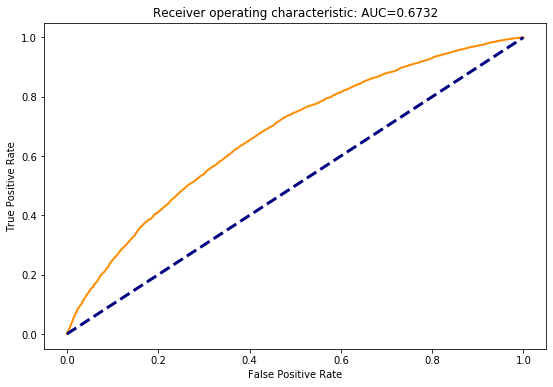

In [52]:
plot_auc(final_test)

In [53]:
final_test.pr_auc()

0.31958365279517903

### AutoML
Automated machine learning (AutoML) is the process of automating applying machine learning . AutoML tends to automate the maximum number of steps in an ML pipeline without compromising the model’s performance. H2o's AutoMl test multiple ML alogirtm ranging from Random to Artificial Neural Networks. 

In [54]:
aml = H2OAutoML(max_models=20, seed=1,balance_classes= True, stopping_metric='AUC',
                stopping_rounds=3,stopping_tolerance=0.01)
aml.train(list(predictors),target,training_frame=train_hex)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [55]:
aml.leaderboard

model_id,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20191124_200017,0.671319,0.463645,0.37236,0.384189,0.147602
StackedEnsemble_AllModels_AutoML_20191124_200017,0.66964,0.463785,0.373938,0.384211,0.147618
GLM_grid_1_AutoML_20191124_200017_model_1,0.668481,0.462463,0.378118,0.383746,0.147261
GBM_5_AutoML_20191124_200017,0.655476,0.471794,0.38115,0.387084,0.149834
GBM_1_AutoML_20191124_200017,0.647381,0.472775,0.39341,0.387325,0.15002
GBM_2_AutoML_20191124_200017,0.640731,0.479206,0.397167,0.388923,0.151261
GBM_grid_1_AutoML_20191124_200017_model_1,0.638025,0.487719,0.398388,0.393382,0.154749
GBM_3_AutoML_20191124_200017,0.637278,0.488952,0.400729,0.391454,0.153236
DRF_1_AutoML_20191124_200017,0.635269,0.52601,0.39834,0.401855,0.161487
XRT_1_AutoML_20191124_200017,0.634605,0.527078,0.399834,0.402028,0.161626


In [58]:
aml_test = aml.leader.model_performance(test_full)

In [59]:
aml_test.gains_lift()


Gains/Lift Table: Avg response rate: 19.29 %, avg score: 18.56 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010040,0.502449,2.378415,2.378415,0.458874,0.566498,0.458874,0.566498,0.023879,0.023879,137.841486,137.841486
1,,2,0.020037,0.447823,2.523968,2.451034,0.486957,0.471167,0.472885,0.518936,0.025231,0.049110,152.396838,145.103375
2,,3,0.030033,0.412951,2.276079,2.392800,0.439130,0.429462,0.461650,0.489154,0.022753,0.071863,127.607863,139.279978
3,,4,0.040030,0.389062,2.343685,2.380534,0.452174,0.400600,0.459283,0.467040,0.023429,0.095292,134.368493,138.053440
4,,5,0.050026,0.369114,1.870441,2.278604,0.360870,0.378282,0.439618,0.449304,0.018698,0.113990,87.044086,127.860432
5,,6,0.100009,0.307758,1.712693,1.995772,0.330435,0.335212,0.385050,0.392283,0.085605,0.199595,71.269283,99.577155
6,,7,0.150035,0.270032,1.679683,1.890378,0.324066,0.287665,0.364716,0.357400,0.084028,0.283622,67.968263,89.037805
7,,8,0.200017,0.243888,1.397197,1.767136,0.269565,0.255786,0.340939,0.332007,0.069836,0.353458,39.719678,76.713632
8,,9,0.300026,0.207159,1.324508,1.619593,0.255541,0.224525,0.312473,0.296180,0.132462,0.485920,32.450753,61.959339
9,,10,0.399991,0.181418,1.160575,1.504876,0.223913,0.193793,0.290340,0.270592,0.116017,0.601937,16.057475,50.487614


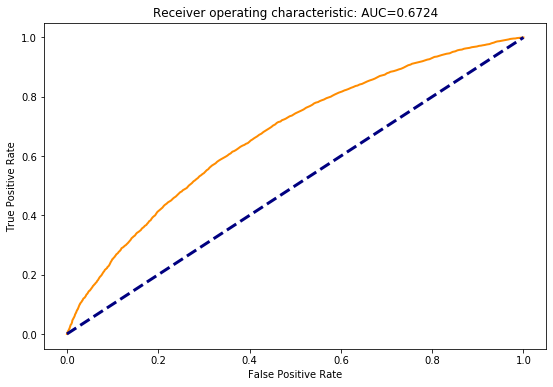

In [60]:
plot_auc(aml_test)

Conlusion: 

I was really surprised by the predictive power of Generalized linear models in unbalanced datasets. It performed better than the random forest model, which leads me to conclude that there's a linear relationship between the variables and the predictor values in the dataset. 

AutoML is an extremely powerful to achieve a high level prediction relatively quickly. However it does have it's limitation, the model ovefitted the training datas and wasn't able to generalize to new data set. 

#### Reference:
[What Are the Effects of Multicollinearity and When Can I Ignore Them?](https://blog.minitab.com/blog/adventures-in-statistics-2/what-are-the-effects-of-multicollinearity-and-when-can-i-ignore-them)<br>
[Regularization Part 2: Lasso Regression](https://www.youtube.com/watch?v=NGf0voTMlcs)<br>
[Regularization Part 1: Ridge Regression](https://www.youtube.com/watch?v=Q81RR3yKn30&t=503s)